# Assignment 1


In [177]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
from __future__ import division

In [178]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
dim = 100
window_size = 2 #use this window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #use this window size for the co-occurrence matrix

## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


In [179]:
#create co-occurrence matrix

np.set_printoptions(threshold=np.nan)
coMatrix=np.zeros((V, V), np.int8)

def processSentence(sentence):
    # Run over the sentence from all words as a co-occurrence
    for w1 in range(0, len(sentence)):
        word1 = sentence[w1]
        
        # Set window size
        window = []
        for x in range(1, window_size_corpus+1):
            window.append(w1+x)
            window.append(w1-x)
        
        # Compare w1 to every w2 in the window size 
        for w2 in window:
            if w2 >= 0 and w2 < len(sentence):
                word2 = sentence[w2]
                if(word1 != word2):
                    coMatrix[word1][word2] += 1

for sentence in corpus:
    processSentence(sentence)

# Normalize data to  be a percentage (value between 0 and 1, depending on the maximum value in the entire matrix).
divMatrix = np.zeros((V,V))
maximum = coMatrix.max()
divMatrix.fill(maximum)
coMatrix = np.divide(coMatrix, divMatrix)

In [180]:
#find cosine similarity to Alice, Dinah and Rabbit

dictionary = tokenizer.word_index
alice = dictionary['alice']
rabbit = dictionary['rabbit']
dinah = dictionary['dinah']

print("Cosine similarity between Alice and Rabbit:")
print(cosine_similarity(coMatrix[alice].reshape(1, -1), coMatrix[rabbit].reshape(1, -1)))
print("\nCosine similarity between Alice and Dinah:")
print(cosine_similarity(coMatrix[alice].reshape(1, -1), coMatrix[dinah].reshape(1, -1)))
print("\nCosine similarity between Dinah and Rabbit:")
print(cosine_similarity(coMatrix[dinah].reshape(1, -1), coMatrix[rabbit].reshape(1, -1)))

Cosine similarity between Alice and Rabbit:
[[0.47890931]]

Cosine similarity between Alice and Dinah:
[[0.39360011]]

Cosine similarity between Dinah and Rabbit:
[[0.29862324]]


In [181]:
#find the closest words to Alice

#Find nearest neighbors
neighbors = nn(n_neighbors=6)
neighbors.fit(coMatrix) 
similars = (neighbors.kneighbors(coMatrix[alice].reshape(1, -1))[1])[0]

#translate ids back into words:
for word in similars:
    print(list(dictionary.keys())[list(dictionary.values()).index(word)])

alice
her
that
herself
for
on


# 1.4 Discussion of the five closest words to Alice:
The five closest words contain in our opinion two general groups. The so referred to as 'filler' words, containing the words "that", "for", and "on", and the 'referal' words, containing the words "her", and "herself". 

The filler words contain words which are very common in the English language and do not have any semantic meaning. The corpus contained the entirety of the 'Alice in Wonderland' book, including words such as that, for, on, the, a, etc., which means that these common words will be more present in the book. Especially when comparing it to words with semantic meaning, which will not be present in almost every sentence as opposed to such filler words. It is not a surprise that these filler words are among the closest neighbors to Alice, but unfortunately there's not a lot which can be learned from their presence. It is probably better to eliminate filler words such as these from the corpus before performing comparison tasks such as these. 

The referal words contain the words her, and herself. These words are also very common in the English language, but are slightly different as they are used to refer to a person or used as a possesive indication. Both her, and herself are used to refer to female people, which in this case will most often have been used to refer to Alice, or items belonging to Alice. Not much can be learned from this, apart from gender. In other cases, it is probably better to elimate these kinds of words from the corpus as well.

# 1.5 Discussion of the drawbacks of a term-term co-occurrence matrix solutions:

The main drawbacks of a term-term co-occurence matrix are that the matrices will be sparse, the matrices will be very large, and it is not very useful for many tasks. 

The matrix of a term-term co-occurrence matrix solution will be very sparse, in other words, it will contain a lot of zeroes compared to the amount of usefull data (useful data is anything between 0 and 1 NOT including 0 in our case). This spacious data will be a drain on a system as its operations and memory are wasted on the zeros, especially if standard operations made for dense matrices are used. It also makes it difficult for someone to visually inspect and explore the data during analysis, requiring them to completely rely on the operations done by the computer.

Due to the large amount of words in any usefull corpus, the matrix of this co-occurrence matrix solutions will also be very large. This will result in requiring a lot of memory for the matrix, difficulty with visually inspecting and exploring the data, and making it necessary to rely on operations and algorithms to process the data correct.

A term-term co-occurrence matrix solution is useful for comparing words, but is not very useful for a general inspection or exploration of a document.

In [182]:
#Save your all the vector representations of your word embeddings in this way
#Change when necessary the sizes of the vocabulary/embedding dimension
f = open('vectors_co_occurrence.txt',"w")

# Write all the words in the file
f.write(" ".join([str(V-1),str(V-1)]))
f.write("\n")

#vectors = your word co-occurrence matrix
vectors = coMatrix[:,1:]
for word, i in tokenizer.word_index.items():    
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

In [183]:
#reopen your file as follows

co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)

## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


In [36]:
#prepare data for cbow

def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)

            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            y = np_utils.to_categorical(labels, V)
            yield (x, y)

In [37]:
#create CBOW model
dim=50
cbow50 = Sequential()
cbow50.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow50.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow50.add(Dense(V, activation='softmax'))

dim=150
cbow150 = Sequential()
cbow150.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow150.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow150.add(Dense(V, activation='softmax'))

dim=300
cbow300 = Sequential()
cbow300.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow300.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow300.add(Dense(V, activation='softmax'))

In [38]:
#define loss function
loss='categorical_crossentropy'

In [39]:
#train cbow50 model
cbow50.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow50.train_on_batch(x, y)

    print(ite, loss)
    
    
f = open('cbow_50_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 50))
vectors = cbow50.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 41686.856939315796
1 39117.07975804806
2 38908.93960213661


In [40]:
#train cbow150 model
loss='categorical_crossentropy'
cbow150.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow150.train_on_batch(x, y)

    print(ite, loss)
    
    
f = open('cbow_150_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 150))
vectors = cbow150.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 41624.23085522652
1 38758.48308968544
2 38354.18330681324


In [41]:
#train cbow300 model
loss='categorical_crossentropy'
cbow300.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow300.train_on_batch(x, y)

    print(ite, loss)
    
f = open('cbow_300_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 300))
vectors = cbow300.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 41559.90414094925
1 38492.52104020119
2 37942.09509307146


In [42]:
#prepare data for Skipgram

def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    in_words.append([word])
                    labels.append(words[i])
            if in_words != []:
                all_in.append(np.array(in_words,dtype=np.int32))
                all_out.append(np_utils.to_categorical(labels, V))
    return (all_in,all_out)

#get x and y's for data
x,y = generate_data_skipgram(corpus,window_size,V)

#save the preprocessed data of Skipgram
f = open('data_skipgram.txt' ,'w')

for inputs, outcome in zip(x,y):
    inputs = np.concatenate(inputs)
    f.write(" ".join(map(str, list(inputs))))
    f.write(",")
    outcome = np.concatenate(outcome)
    f.write(" ".join(map(str,list(outcome))))
    f.write("\n")
f.close()

In [43]:
#load the preprocessed Skipgram data
def generate_data_skipgram_from_file():
    f = open('data_skipgram.txt' ,'r')
    for row in f:
        inputs,outputs = row.split(",")
        inputs = np.fromstring(inputs, dtype=int, sep=' ')
        inputs = np.asarray(np.split(inputs, len(inputs)))
        outputs = np.fromstring(outputs, dtype=float, sep=' ')
        outputs = np.asarray(np.split(outputs, len(inputs)))
        yield (inputs,outputs)

In [44]:
#create Skipgram model
dim=50
skipgram50 = Sequential()
skipgram50.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram50.add(Reshape((dim, )))
skipgram50.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

dim=150
skipgram150 = Sequential()
skipgram150.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram150.add(Reshape((dim, )))
skipgram150.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

dim=300
skipgram300 = Sequential()
skipgram300.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram300.add(Reshape((dim, )))
skipgram300.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

In [45]:
#define loss function for Skipgram

In [46]:
#train Skipgram50 model

skipgram50.compile(loss='categorical_crossentropy', optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram50.train_on_batch(x, y)

    print(ite, loss)
    
f = open('skipgram_50_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 50))
vectors = skipgram50.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 41271.78884887695
1 39101.341372966766
2 39265.00240945816


In [47]:
#train Skipgram150 model
loss='categorical_crossentropy'
skipgram150.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram150.train_on_batch(x, y)

    print(ite, loss)
    
f = open('skipgram_150_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 150))
vectors = skipgram150.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 41215.38952541351
1 38922.67157101631
2 38985.02361166477


In [48]:
#train Skipgram300 model
loss='categorical_crossentropy'
skipgram300.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram300.train_on_batch(x, y)

    print(ite, loss)
    
f = open('skipgram_300_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 300))
vectors = skipgram300.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 41158.67087030411
1 38737.37133550644
2 38703.309982299805


# 2.3 Add an extra hidden dense layer to the CBOW and Skipgram implementations. Choose an activation function for that layer and justify your answer.

We chose to add an extra layer before the final dense layer in all of the models. Because it is an intermediate layer, using the Rectified Linear Unit activation function made most sense. ReLU in practice means that the neuron only passes on relevant signals and in general seems to give a good approximation.

In [63]:
#create CBOW model with additional dense layer
dim=50
cbow50h = Sequential()
cbow50h.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow50h.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow50h.add(Dense(V, activation='relu'))
cbow50h.add(Dense(V, activation='softmax'))

dim=150
cbow150h = Sequential()
cbow150h.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow150h.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow150h.add(Dense(V, activation='relu'))
cbow150h.add(Dense(V, activation='softmax'))

dim=300
cbow300h = Sequential()
cbow300h.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow300h.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow300h.add(Dense(V, activation='relu'))
cbow300h.add(Dense(V, activation='softmax'))

In [64]:
#define loss function for CBOW + dense


In [66]:
#train model for CBOW + dense
loss='categorical_crossentropy'
cbow50h.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow50h.train_on_batch(x, y)

    print(ite, loss)
    
f = open('cbowh_50_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 50))
vectors = cbow50h.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()



0 38203.86327829957
1 38013.09641942382
2 37855.625559709966


In [67]:
loss='categorical_crossentropy'
cbow150h.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow150h.train_on_batch(x, y)

    print(ite, loss)
    
f = open('cbowh_150_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 150))
vectors = cbow150h.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 39556.89970886707
1 38192.07329599559
2 37617.63297378272


In [69]:
loss='categorical_crossentropy'
cbow300h.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow300h.train_on_batch(x, y)

    print(ite, loss)
    
f = open('cbowh_300_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 300))
vectors = cbow300h.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 37681.00657823682
1 37109.283381693065
2 36645.58560779132


In [142]:
#create Skipgram with additional dense layer
from keras.layers import Dropout

dropout_rate = 0.2
dim=50
skipgram50h = Sequential()
skipgram50h.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram50h.add(Reshape((dim, )))
skipgram50h.add(Dense(units=V, activation='relu'))
skipgram50h.add(Dense(units=V, kernel_initializer='uniform', activation='softmax'))

dim=150
skipgram150h = Sequential()
skipgram150h.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram150h.add(Reshape((dim, )))
skipgram150h.add(Dense(units=V, activation='relu'))
skipgram150h.add(Dense(units=V, kernel_initializer='uniform', activation='softmax'))

dim=300
skipgram300h = Sequential()
skipgram300h.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram300h.add(Reshape((dim, )))
skipgram300h.add(Dense(units=V, activation='relu'))
skipgram300h.add(Dense(units=V, kernel_initializer='uniform', activation='softmax'))

In [143]:
#define loss function for Skipgram + dense


In [144]:
#train model for Skipgram + dense
skipgram50h.compile(loss='categorical_crossentropy', optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram50h.train_on_batch(x, y)

    print(ite, loss)
    
f = open('skipgramh_50_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 50))
vectors = skipgram50h.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 38556.30892801285
1 38284.277649879456
2 38160.48908627033


In [145]:
loss='categorical_crossentropy'
skipgram150h.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram150h.train_on_batch(x, y)

    print(ite, loss)
    
f = open('skipgramh_150_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 150))
vectors = skipgram150h.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 38524.81856560707
1 38182.9237254858
2 38044.449105620384


In [146]:
loss='categorical_crossentropy'
skipgram300h.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram300h.train_on_batch(x, y)

    print(ite, loss)
    
f = open('skipgramh_300_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 300))
vectors = skipgram300h.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 38556.01204943657
1 38273.90782046318
2 38062.221319675446


# 4. Analyze the four different word embeddings through your own analogy function

In [199]:
#Implement your own analogy function

from math import *
from math import sqrt

def dot(v1, v2):
    return sum(x*y for x, y in zip(v1, v2))

def length(v1):
    return sqrt(dot(v1, v1))

def calculate_analogy(v1, v2, v3, v4):
    #Calculate v1 -v2 + v4 to compare to v3
    lhs_intermed = map(float.__sub__, v1, v2)
    lhs = list(map(float.__add__, lhs_intermed, v4))
    rhs = v3
    #Calculate normalized cosine similarity between the two sides of the equation
    return dot(lhs, rhs) / (length(lhs) * length(rhs))

# options: cbow_50, cbow_150, cbow_300, cbowh_50, cbowh_150, cbowh_300
# skipgram_50, skipgram_150, skipgram_300, skipgramh_50, skipgramh_150, skipgramh_300
def retrieve_analogy(word1, word2, word3, word4, db):
    filename = ''+db+'_vectors.txt'
    vectorDict = {}
    f = open(filename, 'r')
    for line in f:
        word, vector = line.partition(" ")[::2]
        vectorDict[word.strip()] = [float(v) for v in vector.split(" ")]
    vector1 = vectorDict[word1]
    vector2 = vectorDict[word2]
    vector3 = vectorDict[word3]
    vector4 = vectorDict[word4]
    return calculate_analogy(vector1, vector2, vector3, vector4)

word1 = "cat"
word2 = "cats"
word3 = "dog"
word4 = "dogs"

cbow50_similarity = retrieve_analogy(word1, word2, word3, word4, "cbow_50")
cbow150_similarity = retrieve_analogy(word1, word2, word3, word4, "cbow_150")
cbow300_similarity = retrieve_analogy(word1, word2, word3, word4, "cbow_300")
print(cbow50_similarity, cbow150_similarity, cbow300_similarity)

cbow50h_similarity = retrieve_analogy(word1, word2, word3, word4, "cbowh_50")
cbow150h_similarity = retrieve_analogy(word1, word2, word3, word4, "cbowh_150")
cbow300h_similarity = retrieve_analogy(word1, word2, word3, word4, "cbowh_300")
print(cbow50h_similarity, cbow150h_similarity, cbow300h_similarity)

skipgram50_similarity = retrieve_analogy(word1, word2, word3, word4, "skipgram_50")
skipgram150_similarity = retrieve_analogy(word1, word2, word3, word4, "skipgram_150")
skipgram300_similarity = retrieve_analogy(word1, word2, word3, word4, "skipgram_300")
print(skipgram50_similarity, skipgram150_similarity, skipgram300_similarity)

skipgram50h_similarity = retrieve_analogy(word1, word2, word3, word4, "skipgramh_50")
skipgram150h_similarity = retrieve_analogy(word1, word2, word3, word4, "skipgramh_150")
skipgram300h_similarity = retrieve_analogy(word1, word2, word3, word4, "skipgramh_300")
print(skipgram50h_similarity, skipgram150h_similarity, skipgram300h_similarity)

-0.2980165991132072 -0.20327956860411506 -0.11952502487146552
0.10905394763760211 -0.01361964239572564 -0.028799639720151007
0.0669543422656621 -0.08060258112348465 -0.031504496879157455
0.04876081221864342 -0.14485312389165422 0.038133865161932595


In [221]:
#Create a 2D array of the results of the previous question
row1 = [cbow50_similarity, cbow150_similarity, cbow300_similarity]
row2 = [cbow50h_similarity, cbow150h_similarity, cbow300h_similarity]
row3 = [skipgram50_similarity, skipgram150_similarity, skipgram300_similarity]
row4 = [skipgram50h_similarity, skipgram150h_similarity, skipgram300h_similarity]

mappingArray = []
mappingArray.append(row1)
mappingArray.append(row2)
mappingArray.append(row3)
mappingArray.append(row4)
print(mappingArray)

[[-0.2980165991132072, -0.20327956860411506, -0.11952502487146552], [0.10905394763760211, -0.01361964239572564, -0.028799639720151007], [0.0669543422656621, -0.08060258112348465, -0.031504496879157455], [0.04876081221864342, -0.14485312389165422, 0.038133865161932595]]


Comparison performance:

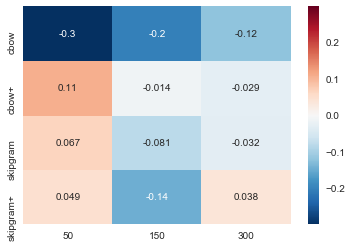

In [222]:
#Visualization results trained word embeddings
%matplotlib inline

import numpy as np
import seaborn as sns

names = ["cbow", "cbow+", "skipgram", "skipgram+"]
sizes = ["50", "150", "300"]
ax = sns.heatmap(mappingArray,  annot=True,  yticklabels=names, xticklabels=sizes)

# 4.c Interpretation results of the visualization

When looking at the heatmap of the results, they seem all over the place. However, there are some insights to be found. First of all, when looking at the average cosine similarity, the SkipGram models seem to perform well, retrieving mostly positive values. 

Another thing that jumps out is that almost all values are negative, except for those belonging to the embedding vectors of length 50. As cosine similarity does not depend on the size of the vector, this finding is not explained by such a factor. However, we do know that with a smaller embedding vector, more information is encoded in each dimension. This means that, depending on the other words in the vocabulary, a lower dimension could mean higher similarity measures. 

Important to notice is the fact that all measures are very close to zero, which means that either the model or the source does not show signals to support the analogy as calculated above.


# 5 Compare the results of the trained word embeddings with the word-word co-occurrence matrix

Surprisingly, on the analogy we chose, the co-occurence matrix vectors were not similar at all, as is reflected in the cosine similarity. We have checked multiple times whether this was correct, but as vector 3 contains many zeroes, the dot product returns a zero for this analogy. Given the other values that we have retrieved so far, this does not seem strange at all. It looks like the corpus was not big enough to train these semantics as required. 

In [223]:
dictionary = tokenizer.word_index

v1 = coMatrix[dictionary[word1]]
v2 = coMatrix[dictionary[word2]]
v3 = coMatrix[dictionary[word3]]
v4 = coMatrix[dictionary[word4]]

distance = calculate_analogy(v1, v2, v3, v4)

In [224]:
# Add the same measure three times in order to easily add it to the heatmap
mappingArray.append([distance, distance, distance])
names.append("co-occurence")

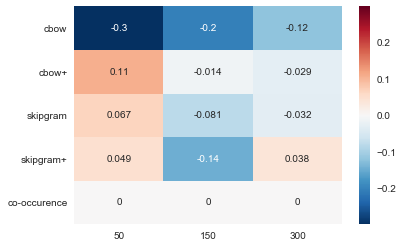

In [225]:
ax = sns.heatmap(mappingArray, annot=True, yticklabels=names, xticklabels=sizes)

# 6 Discussion of the advantages of CBOW and Skipgram, the advantages of negative sampling and drawbacks of CBOW and Skipgram

**Advantages of CBOW and Skipgram:** 

CBOW and Skipgram have a number of advantages. CBOW and Skipgram have a lower internal complexity compared to older models, which means that it can be trained on a lot more data much more efficiently. The models also have the ability to complete more complex similarity tasks, e.g. being able to denote a similarity between *big*, *bigger* and *small*, *smaller*. The models also are able to represent very subtle semantic relationships, compared to other models. 

**Advantages of negative sampling:**

A disadvantage of CBOW and Skipgram with word processing is the hugh amount of weights which need to be updated every single run while training. Negative sampling allows more efficient training of a model, due to the significantly reduced amount of weights which are updated every run. 

If Subsampling was applied to frequent words, before applying negative sampling, not only reduces the computational burden of training, but also improves the quality of the resulting word vectors.

**Drawbacks of CBOW and Skipgram:**

One drawback of CBOW and Skipgram is that words with multiple meaning can only be interpreted once. Which means it will only interpet all meanings at the same time, which would not provide a good representation for words with multiple meanings.

Another drawback of CBOW and Skipgram is that the models only look at words and the window around it, but not to the order of the words within the window. The order of words can be important as meanings can change depending on it, such as *race horse*, and *horse race*. Two words which have a different semantic meaning, but will be treated as the same thing by CBOW and Skipgram.

Depending on the size of the corpus, there can be an extremely large number of weights to be altered during trainnig, especially if dropout or negative sampling is not used.

# 7 Compare performance of your models with the pre-trained embeddings

In [226]:
#load pretrained word embeddings of word2vec

path_word2vec = 'GoogleNews-vectors-negative300.bin'

word2vec = KeyedVectors.load_word2vec_format(path_word2vec, binary=True)

In [227]:
# Add word2vec similarity to heatmap:

v1 = word2vec[word1]
v2 = word2vec[word2]
v3 = word2vec[word3]
v4 = word2vec[word4]

def numpy_calculate_analogy(v1, v2, v3, v4):
    #Calculate v1 -v2 + v4 to compare to v3
    lhs_intermed = v1 - v2
    lhs = lhs_intermed + v4
    rhs = v3
    #Calculate normalized cosine similarity between the two sides of the equation
    return dot(lhs, rhs) / (length(lhs) * length(rhs))

distance = numpy_calculate_analogy(v1, v2, v3, v4)

In [228]:
# Add everything to the appropriate arrays
mappingArray.append([distance, distance, distance])
names.append("word2vec")

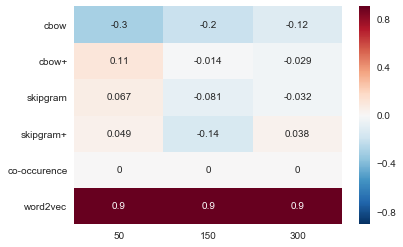

In [229]:
# Create a new heatmap
ax = sns.heatmap(mappingArray, annot=True, yticklabels=names, xticklabels=sizes)

In [146]:
#load pretraind word embeddings of Glove
import gensim

path = "glove.6B/glove.6B.300d.txt"

#convert GloVe into word2vec format
gensim.scripts.glove2word2vec.get_glove_info(path)
gensim.scripts.glove2word2vec.glove2word2vec(path, "glove_converted.txt")

glove = KeyedVectors.load_word2vec_format("glove_converted.txt", binary=False)

In [230]:
# Add word2vec similarity to heatmap:

v1 = glove[word1]
v2 = glove[word2]
v3 = glove[word3]
v4 = glove[word4]

distance = numpy_calculate_analogy(v1, v2, v3, v4)

In [231]:
# Add everything to the appropriate arrays
mappingArray.append([distance, distance, distance])
names.append("glove")

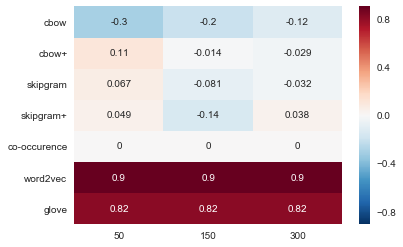

In [232]:
# Create a new heatmap
ax = sns.heatmap(mappingArray, annot=True, yticklabels=names, xticklabels=sizes)

After the addition of the Word2Vec and GloVe embeddings, the entire mapping has become completely skewed. The similarities measured in this embedding between the four words is much higher than the figures we have previously seen. As cosine similarity has a maximum value of 1, these corpora show us that the problem was not in the analogy but actually due to the size of the Alice in Wonderland corpus. 

We can also reason the other way around. We knew that the analogy was correct, and actually very strong. The fact that both Word2Vec and GloVe return such high similarity measures shows us that it has been trained on a lot of data and is very powerful. 

It actually is not even fair to compare our self-trained models here, as they did not even get a chance to grow powerful in the limited amount of time, with the limited amount of computation power available. However, this does show what a good word embedding can do and what a powerful tool it is. 
